In [3]:
import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv

%matplotlib inline

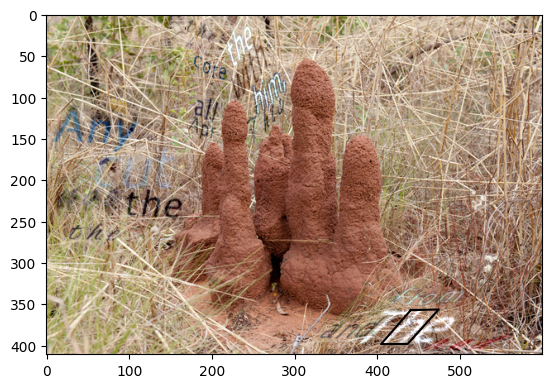

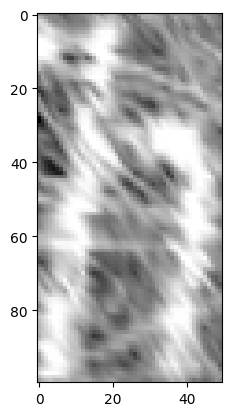

In [4]:
file_name = 'Project/SynthText_train.h5'

db = h5py.File(file_name, 'r')
db_data = db['data']

im_names = list(db_data.keys()) 

im_name = im_names[0]
img = db_data[im_name][:]
font = db_data[im_name].attrs['font']
txt = db_data[im_name].attrs['txt']
charBB = db_data[im_name].attrs['charBB']
wordBB = db_data[im_name].attrs['wordBB']

# print(f'{font.shape = } {txt.shape = } {charBB.shape = } {wordBB.shape = }')
# print(font[0])
# print(charBB[:,:,0])
# print(np.array(list(charBB[:,i,0] for i in range(charBB.shape[1]))))
idx = 1
src_points = np.array(list(charBB[:,i,idx] for i in range(charBB.shape[1])), dtype=np.float32)

plt.imshow(img)
plt.plot(np.append(charBB[0,:,idx], charBB[0,0,idx]), np.append(charBB[1,:,idx], charBB[1,0,idx]), c='black')
plt.show()

shape = (50, 100)
dst_points = np.array([[0,0], [50, 0], [50, 100], [0, 100]], dtype=np.float32)


# print(f'{src_points.shape = }\n{dst_points.shape = }')
proj_matrix = cv.getPerspectiveTransform(src_points, dst_points)
out_img = cv.warpPerspective(img, proj_matrix, shape)

# plt.imshow(out_img)
plt.imshow(out_img.mean(axis=2), cmap='gray')
plt.show()